3D volumetric rendering using NeRF.
- each ray passes through a 3D field of densities mu(x,y,z)
- we render an image by evaluating one ray per pixel
- I = exp - sum_i mu_i delta_s_i

1: Define a 3D voxel density field mu(x,y,z)
- basically, a set of objects with densities in a 3D volume

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# --- Volume definition (your existing mu) ---
Nx, Ny, Nz = 64, 64, 64
mu = np.zeros((Nx, Ny, Nz), dtype=np.float32)

# cube 1
mu1 = 0.1
mu[0:20, 0:20, 0:30] = mu1

# cube 2
mu2 = 0.5
mu[30:35, 30:35, 0:30] = mu2

# sphere
mu3 = 0.3
cx, cy, cz, r = 48, 48, 48, 10
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), np.arange(Nz), indexing='ij')
sphere = (X - cx)**2 + (Y - cy)**2 + (Z - cz)**2 <= r**2
mu[sphere] = mu3

1.1: Show the density volume in 3D

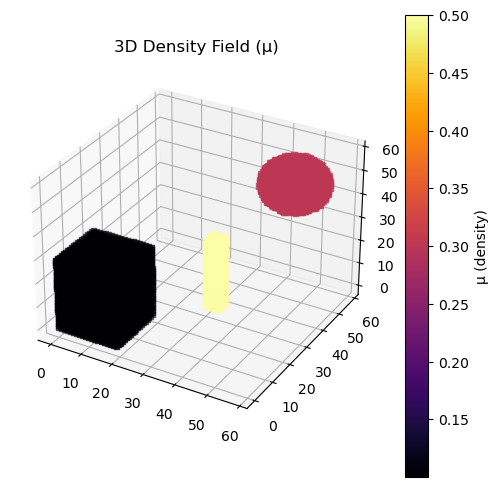

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# pick voxels with density > 0
x, y, z = np.nonzero(mu)
c = mu[x, y, z]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=c, cmap='inferno', marker='s', s=15)
plt.colorbar(p, ax=ax, label='μ (density)')
ax.set_title("3D Density Field (μ)")
plt.show()


2: Define a camera
- we just use a simple orthographic projection

In [24]:
H, W = 64, 64
xs = np.linspace(0, Nx-1, W)
ys = np.linspace(0, Ny-1, H)
zs = np.full((H, W), Nz-1)   # same z for all rays

X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
origins = np.stack([X[...,0], Y[...,0], Z[...,0]], axis=-1).reshape(-1, 3)

directions = np.tile(np.array([0, 0, -1]), (H*W, 1))


In [17]:
print(origins.shape)
print(directions.shape)

(4096, 3)
(4096, 3)


3: March rays through the voxel grid
- for each ray, sample along its path and integrate the attenuation

In [25]:
def render_volume(mu, origins, directions, step=1.0):
    Nx, Ny, Nz = mu.shape
    img = np.zeros(len(origins))
    for i, (o, d) in enumerate(zip(origins, directions)):
        intensity = 1.0 # I_s = 1.0
        pos = o.copy()
        # check out-of-bounds
        while 0 <= pos[0] < Nx and 0 <= pos[1] < Ny and 0 <= pos[2] < Nz:
            ix, iy, iz = np.round(pos).astype(int)
            intensity *= np.exp(-mu[ix, iy, iz] * step)
            pos += d * step
        img[i] = intensity
    return img

img = render_volume(mu, origins, directions, step=0.5)
img = img.reshape(H, W)

4: Visualize the rendered projection

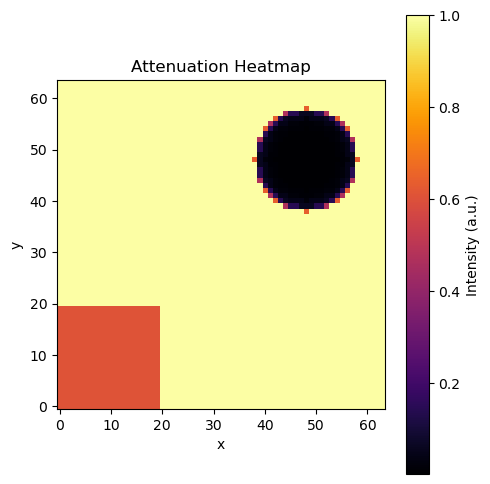

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='inferno', origin='lower')
plt.title("Attenuation Heatmap")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Intensity (a.u.)")
plt.tight_layout()
plt.show()
